## Anomaly Detection in Sensor Data

In [1]:
# Datasource: https://www.kaggle.com/datasets/aniruddhaponnuri/sensor-data

### Create pipeline

In [2]:
"""
Notebook structure:
1. Introduction and objectives
2. Data loading from local CSV
3. Preprocessing and feature engineering
4. Model building and training
5. Modular code organization
"""

# 1. Introduction and objectives
# -------------------------------------------
# - Objective: detect anomalies in sensor readings (e.g., ph) using cleaned measurement data.
# - Algorithms used: IsolationForest, LocalOutlierFactor.

# 2. Data loading from local CSV
# -------------------------------------------
import pandas as pd

def load_data(path: str = 'data/sensor_data_cleaned.csv', sensor_col: str = 'moisture_value') -> pd.DataFrame:
    df = pd.read_csv(path)
    # Convert timestamp column to datetime and set as index
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
    # Remove any duplicate timestamps
    df = df[~df.index.duplicated(keep='first')]
    # Keep only the target sensor column and rename to 'value'
    df = df[[sensor_col]].rename(columns={sensor_col: 'value'})
    return df

# 3. Preprocessing and feature engineering
# -------------------------------------------
def featurize_df(df: pd.DataFrame, window: int = 3) -> pd.DataFrame:
    df = df.resample('min').mean()
    df['value'] = df['value'].bfill().ffill()

    df['rolling_mean'] = (
        df['value']
        .rolling(window, min_periods=1, center=True)
        .mean())

    df['rolling_std'] = (
        df['value']
        .rolling(window, min_periods=1, center=True)
        .std()
        .fillna(0))

    df[['rolling_mean', 'rolling_std']] = (
        df[['rolling_mean', 'rolling_std']]
        .bfill()
        .ffill())

    return df[['value', 'rolling_mean', 'rolling_std']]


# 4. Model building and training
# -------------------------------------------
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

models = {
    'IForest': IsolationForest(contamination=0.03, n_estimators=200, random_state=42),
    'LOF': LocalOutlierFactor(n_neighbors=30, contamination=0.03, novelty=True)
}

def train_models(X: pd.DataFrame, models: dict) -> dict:
    """
    Trains each model on the feature set and returns predictions (-1 anomaly, 1 normal).
    """
    preds = {}
    for name, model in models.items():
        if name == 'LOF':
            model.fit(X.values)
            preds[name] = model.predict(X.values)
        else:
            model.fit(X)
            preds[name] = model.predict(X)
    return preds

# 5. Modular code organization
# -------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

class AnomalyDetector:
    def __init__(self, model, sensor_col, csv_path='data/sensor_data_cleaned.csv'):
        self.model = model
        self.sensor_col = sensor_col
        self.csv_path = csv_path
        self.raw_df = None
        self.X = None

    def load(self):
        df = pd.read_csv(self.csv_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m/%d/%Y %H:%M')
        df = df.set_index('timestamp')
        df = df.rename(columns={self.sensor_col: 'value'})
        self.raw_df = df[['value']]

    def featurize(self):
        self.X = featurize_df(self.raw_df.copy())

    def fit(self):
        self.model.fit(self.X.values)

    def predict(self):
        return self.model.predict(self.X.values)

    def plot(self):
        preds = self.predict()
        times = self.X.index
        vals  = self.X['value']

        plt.figure(figsize=(12,4))
        plt.plot(times, vals, 'b-', label='Value')
        mask = preds == -1
        plt.plot(times[mask], vals[mask], 'ro', label='Anomaly')
        plt.xlabel('Time')
        plt.ylabel(self.sensor_col)
        plt.title(f'Anomaly Detection – {self.sensor_col}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

### Usage

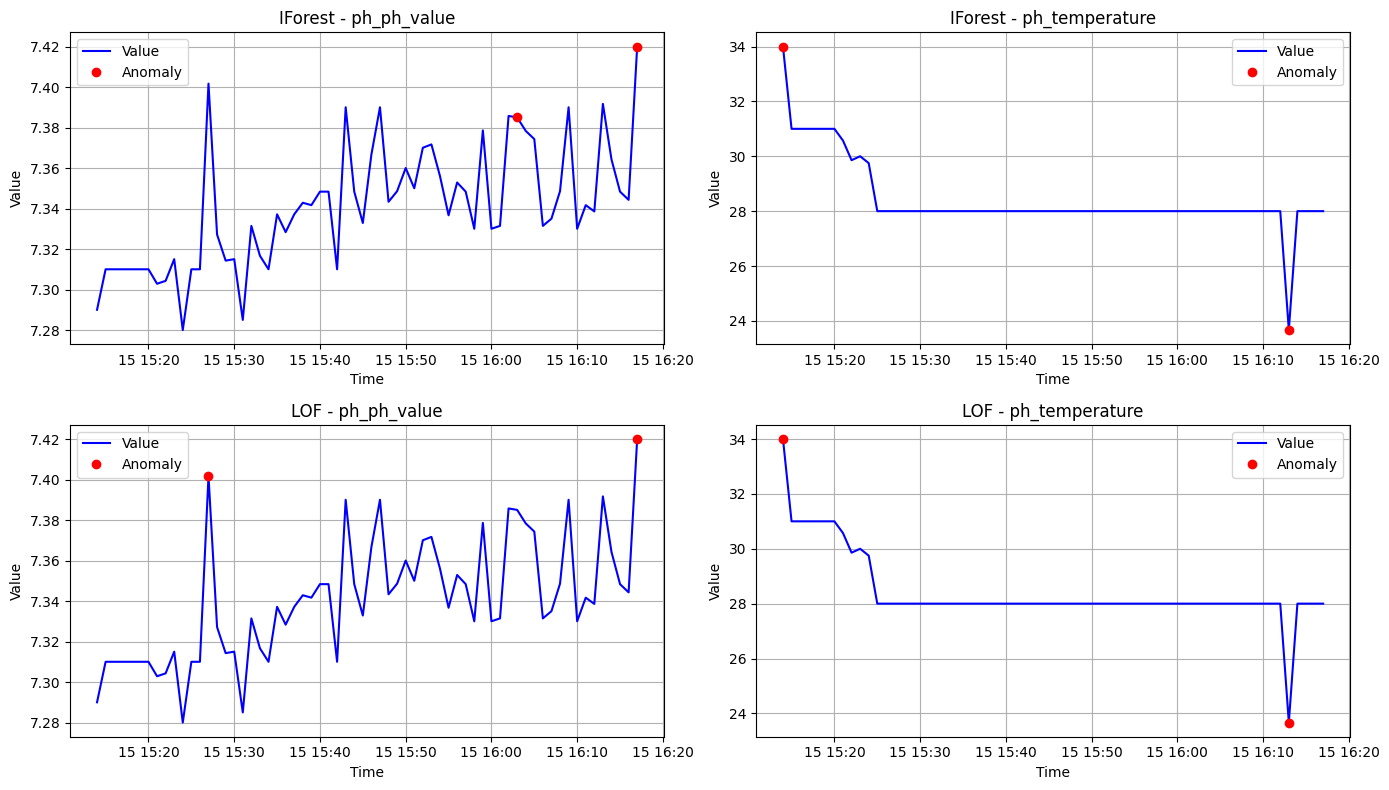

In [3]:
import matplotlib.pyplot as plt

sensor_cols = ['ph_ph_value', 'ph_temperature']
model_names = list(models.keys())

fig, axes = plt.subplots(len(model_names), len(sensor_cols), figsize=(14, 8), sharex=False)

for i, model_name in enumerate(model_names):
    for j, sensor_col in enumerate(sensor_cols):
        # load + feature engineering
        detector = AnomalyDetector(models[model_name], sensor_col=sensor_col)
        detector.load()
        detector.featurize()
        X_feat = detector.X  # pandas DataFrame

        # Model fit and predict
        if model_name == 'LOF':
            detector.model.fit(X_feat.values)
            preds = detector.model.predict(X_feat.values)
        else:
            detector.model.fit(X_feat)
            preds = detector.model.predict(X_feat)

        # Plot
        ax = axes[i, j]
        times = X_feat.index
        vals  = X_feat['value']
        ax.plot(times, vals, 'b-', label='Value')
        mask = preds == -1
        ax.plot(times[mask], vals[mask], 'ro', label='Anomaly')
        ax.set_title(f"{model_name} - {sensor_col}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()

fig.tight_layout()
#plt.savefig('Anomaly detection Sensor Data', dpi=300, bbox_inches='tight')
plt.show()